In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import cv2
import json
import os
from typing import List, Optional
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from pathlib import Path
import sys
sys.path.append("/home/psa_images/SemiF-AnnotationPipeline/segment")
from semif_utils.utils import cutoutmeta2csv

In [17]:
batch_id = 'NC_2022-10-28'
# cutout_dir = "../data/semifield-cutouts/"
# cutout_dir = "/mnt/research-projects/s/screberg/longterm_images/semifield-cutouts/"
cutout_dir = "/home/psa_images/SemiF-AnnotationPipeline/data/semifield-cutouts"
df = cutoutmeta2csv(cutout_dir, batch_id, Path(cutout_dir, batch_id, batch_id + ".csv"), save_df=True)


 32%|███▏      | 2331/7239 [00:03<00:08, 610.45it/s]


KeyboardInterrupt: 

In [7]:
def batch_df(batch_id, cutout_dir, batch_dir):
    df = pd.read_csv(Path(cutout_dir, batch_id, batch_id + ".csv"))
    df["state_id"] = df.batch_id.str.split("_", expand=False).str[0]
    df["date"] = df.batch_id.str.split("_", expand=False).str[1]
    df["image_paths"] = batch_dir + "/images/" + df["image_id"] + ".jpg"
    df["meta_paths"] = batch_dir + "/metadata/" + df["image_id"] + ".json"
    df["semantic_masks"] = batch_dir + "/meta_masks/semantic_masks/" + df["image_id"] + ".png"
    df["instance_masks"] = batch_dir + "/meta_masks/instance_masks/" + df["image_id"] + ".png"
    return df


# Check bbox locations

In [23]:
def read_metadata(path):
    with open(path, 'r') as f:
        data = json.loads(f.read())
    return data


def get_detection_data(jsonpath):
    meta = read_metadata(jsonpath)
    imgwidth, imgheight = meta['width'], meta['height']
    bboxes = meta["bboxes"]
    boxes = []
    labels = []
    for box in bboxes:
        # top_left = box["local_coordinates"]["top_left"]
        # bottom_right = box["local_coordinates"]["bottom_right"]
        
        xywh = box["local_coordinates"]["xywh"]
        w = xywh[2] * imgwidth
        h = xywh[3] * imgheight
        x1 = xywh[0] * imgwidth - w/2
        y1 = xywh[1] * imgheight - h/2
        x2 = x1 + w
        y2 = y1 + h
        
        # x1, y1 = int(top_left[0]*imgwidth), int(top_left[1]*imgheight)
        # x2, y2 = int(bottom_right[0]*imgwidth), int(bottom_right[1]*imgheight)
        print([x1, y1, x2, y2])
        boxes.append([x1, y1, x2, y2])

        label = box["cls"]["common_name"]
        labels.append(label)

    return boxes, labels


def plot_bboxes(image_file,
                bboxes,
                labels,
                xywh,
                save=False,
                save_location=".",
                figsize=(8, 12)):
    """
    Args:
      image_file: str specifying the image file path
      bboxes: list of bounding box annotations for all the detections
      xywh: bool, if True, the bounding box annotations are specified as
        [xmin, ymin, width, height]. If False the annotations are specified as
        [xmin, ymin, xmax, ymax]. If you are unsure what the mode is try both
        and check the saved image to see which setting gives the
        correct visualization.

    """
    fig = plt.figure(figsize=figsize)

    # add axes to the image
    ax = fig.add_axes([0, 0, 1, 1])

    image_name = Path(image_file).name

    # read and plot the image
    image = plt.imread(image_file)
    plt.imshow(image)

    # Iterate over all the bounding boxes
    for i, bbox in enumerate(bboxes):
        if xywh:
            xmin, ymin, w, h = bbox
        else:
            xmin, ymin, xmax, ymax = bbox
            w = xmax - xmin
            h = ymax - ymin

        # add bounding boxes to the image
        box = patches.Rectangle((xmin, ymin),
                                w,
                                h,
                                edgecolor="red",
                                facecolor="none")

        ax.add_patch(box)

        if labels is not None:
            rx, ry = box.get_xy()
            ax.text(rx, (ry - 175),
                    str(labels[i]),
                    verticalalignment='top',
                    color='white',
                    fontsize=10,
                    weight='bold')

    # plt.axis('off')
    plt.show()
    if save:
        outfile = os.path.join(save_location, image_name)
        fig.savefig(outfile)

        print("Saved image with detections to %s" % outfile)

def inspect_masks(df, sample_size, figsize=(8,12),random_state=42):
    dfs = df.sample(sample_size, random_state=random_state)
    for _, df in dfs.iterrows():
        imgpath = df["image_paths"]
        maskpath = df["semantic_masks"]
        instancepath = df["instance_masks"]
        print(imgpath)
        bgr = cv2.imread(imgpath)
        rgbimg = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        bgr = cv2.imread(maskpath)
        rgbmask = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        bgr = cv2.imread(instancepath)
        rgbinstance = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        _, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=figsize)
        ax1.imshow(rgbimg)
        ax2.imshow(rgbmask)
        ax3.imshow(rgbinstance)

        ax1.axis(False)
        ax2.axis(False)
        ax3.axis(False)

        ax1.title.set_text('Color image')
        ax2.title.set_text('Semantic mask')
        ax3.title.set_text('Instance mask')

        plt.tight_layout()
    # plt.savefig(save_cutout_path, bbox_inches="tight", transparent=True, dpi=300)
        plt.show()
        plt.close()

[8342.999572, 2876.0002176, 9294.999668, 4158.0002464]
[6570.00006, 4745.9997152, 8131.999856, 6367.999999999999]
[3862.0000439999994, 4187.5000064000005, 6278.000376, 6200.499948800001]
[6781.999752000001, 1452.5000448, 8306.000460000001, 2883.4998112000003]
[266.0003079999999, 5279.999817599999, 2327.999576, 6282.00016]
[1166.4997279999998, 3820.9999552, 2729.5004559999998, 5210.999990400001]
[536.9995400000003, 1583.0001055999996, 1979.0003040000001, 2839.0002272]
[3543.0000520000003, 2115.4999072, 5289.000212, 3108.4997184000003]
[4152.999752, 5926.000304, 4173.000228, 5958.0001408]


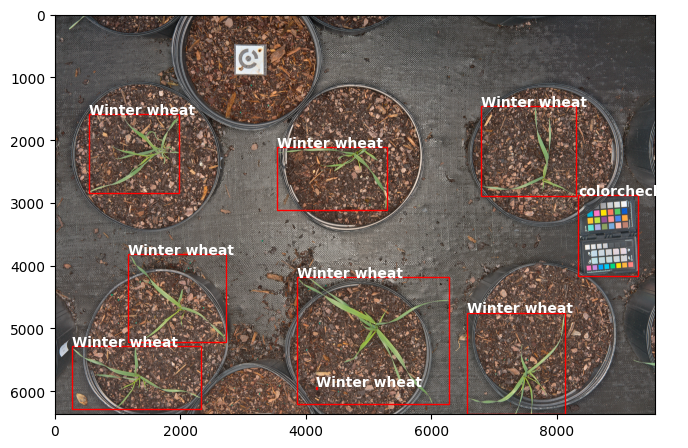

In [24]:
batch_id = 'NC_2022-10-28'
cutout_dir = "../data/semifield-cutouts/"
# cutout_dir = "/mnt/research-projects/s/screberg/longterm_images/semifield-cutouts/"
# batch_dir = f"/mnt/research-projects/s/screberg/longterm_images/semifield-developed-images/{batch_id}"
batch_dir = f"../data/semifield-developed-images/{batch_id}"

# df = cutoutmeta2csv(cutout_dir, batch_id, Path(cutout_dir, batch_id, batch_id + ".csv"), save_df=False)
df = batch_df(batch_id, cutout_dir, batch_dir)
df = df[df["common_name"]=="colorchecker"]
sample_sz = 1
random_state = 42
df = df.drop_duplicates(subset='image_paths', keep="first")
df = df.sample(sample_sz, random_state=random_state)

for idx, i in df.iterrows():
    image_path = i["image_paths"]
    bboxes, labels = get_detection_data(i["meta_paths"])
    plot_bboxes(image_path, bboxes, labels, figsize=(6, 8), xywh=False)

# Check masks

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679081052.jpg


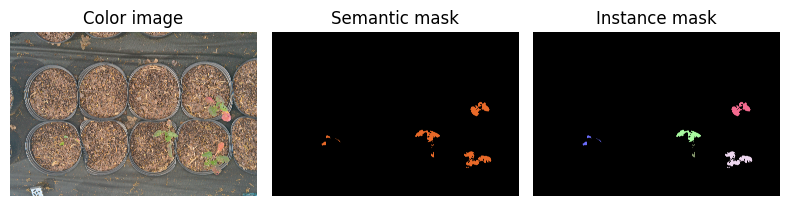

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679085447.jpg


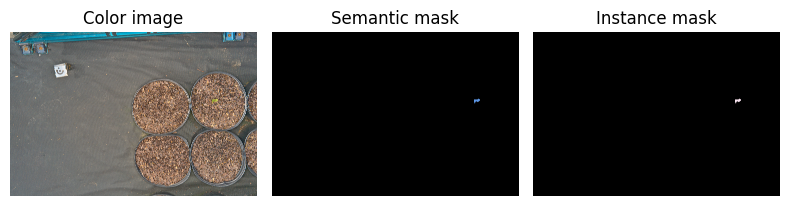

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679078092.jpg


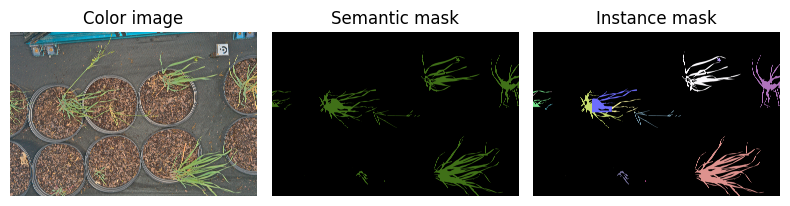

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679084615.jpg


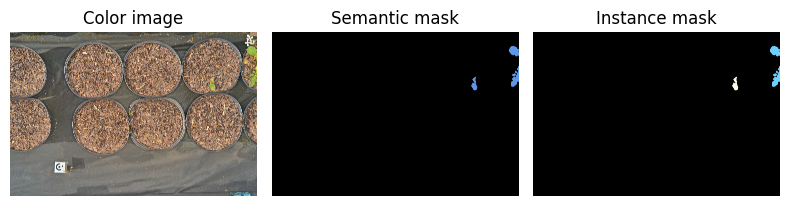

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679084100.jpg


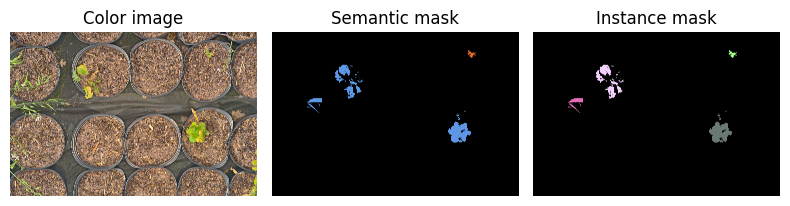

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679078323.jpg


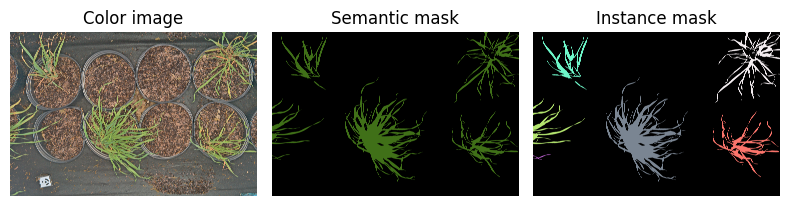

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679085210.jpg


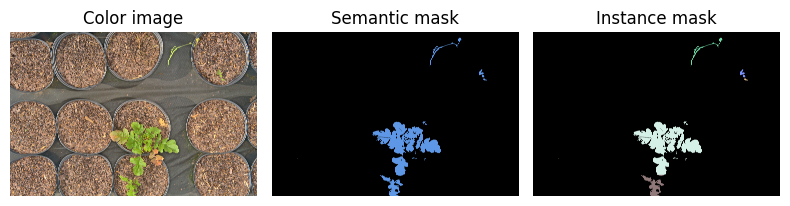

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679084235.jpg


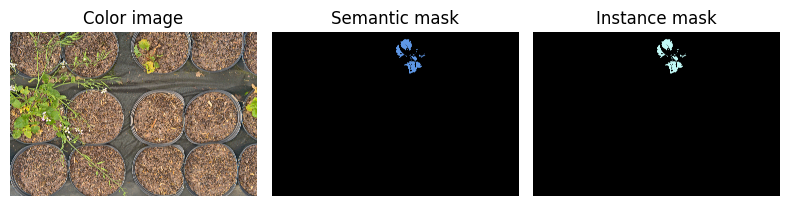

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679075182.jpg


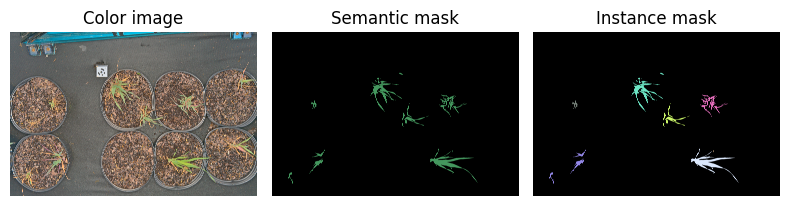

../data/semifield-developed-images/TX_2023-03-17/images/TX_1679074023.jpg


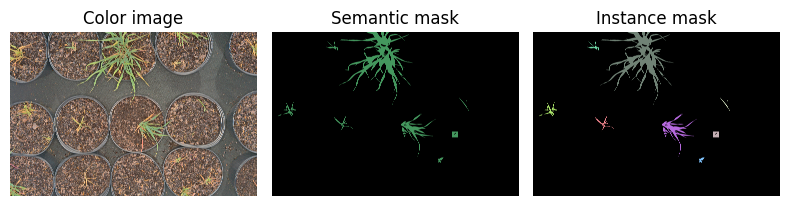

In [40]:
# batch_id = 'TX_2022-11-02'
batch_id = 'TX_2023-03-15'
cutout_dir = "../data/semifield-cutouts/"
batch_dir = f"../data/semifield-developed-images/{batch_id}"

# df = cutoutmeta2csv(cutout_dir, batch_id, Path(cutout_dir, batch_id, batch_id + ".csv"), save_df=False)
df = batch_df(batch_id, cutout_dir, batch_dir)

sample_size = 10
random_state = 12
fgsize = (8,12)
inspect_masks(df, sample_size, figsize=fgsize, random_state=random_state)